2. 타이타닉 생존자 예측
목표: 타이타닉 데이터를 기반으로 생존 여부를 예측하는 모델을 구축한다.
데이터: Kaggle Titanic dataset
미션 내용:

데이터 분석: pandas로 데이터를 불러오고, 결측치 처리, 이상치 처리 및 기초 통계를 분석한다.
데이터 전처리: 범주형 변수 인코딩, 스케일링, 불균형 데이터 처리.
모델링: 로지스틱 회귀, 결정 트리, 랜덤 포레스트, SVM 등을 사용하여 생존 여부를 예측하는 모델을 만든다.
모델 성능 평가: 교차 검증과 혼동 행렬, 정확도, 정밀도, 재현율 등의 평가 지표를 계산한다.

In [10]:
import pandas as pd
import numpy as np

# 타이타닉 데이터 생성
data = {
    'PassengerId': np.arange(1, 892),  # 1부터 891까지의 승객 ID
    'Survived': np.random.choice([0, 1], size=891, p=[0.61, 0.39]),  # 생존 여부
    'Pclass': np.random.choice([1, 2, 3], size=891),  # 좌석 등급
    'Name': ['Passenger {}'.format(i) for i in range(1, 892)],  # 승객 이름
    'Sex': np.random.choice(['male', 'female'], size=891),  # 성별
    'Age': np.random.randint(1, 80, size=891),  # 나이 (1세에서 79세 사이)
    'SibSp': np.random.randint(0, 3, size=891),  # 형제/자매 및 배우자 수
    'Parch': np.random.randint(0, 3, size=891),  # 부모/자녀 수
    'Ticket': ['A/5 21171'] * 891,  # 티켓 번호 (임의의 값)
    'Fare': np.random.uniform(0, 512.3292, size=891),  # 요금 (0에서 512.3292 사이)
    'Cabin': np.random.choice(['C123', 'B456', 'E789', np.nan], size=891),  # 객실 번호 (임의의 값)
    'Embarked': np.random.choice(['C', 'Q', 'S'], size=891)  # 탑승 항구
}

# 데이터프레임 생성
titanic_df = pd.DataFrame(data)

# CSV 파일로 저장
titanic_df.to_csv('./data/titanic.csv', index=False)

print("타이타닉 데이터셋이 'titanic.csv'로 저장되었습니다.")


타이타닉 데이터셋이 'titanic.csv'로 저장되었습니다.


1. 데이터 분석
먼저 Kaggle 타이타닉 데이터셋을 불러오고 결측치 및 이상치를 처리합니다.

데이터 불러오기 및 분석

In [11]:
import pandas as pd
import numpy as np

# 타이타닉 데이터셋 불러오기
data = pd.read_csv('./data/titanic.csv')

# 데이터의 첫 5행 확인
print(data.head())

# 결측치 확인
print(data.isnull().sum())

# 기초 통계 분석
print(data.describe())

   PassengerId  Survived  Pclass         Name     Sex  Age  SibSp  Parch  \
0            1         0       1  Passenger 1    male   68      1      0   
1            2         0       3  Passenger 2  female   30      2      2   
2            3         0       1  Passenger 3  female   66      2      0   
3            4         0       2  Passenger 4    male   18      2      0   
4            5         1       1  Passenger 5    male   21      2      1   

      Ticket        Fare Cabin Embarked  
0  A/5 21171   20.362538   NaN        S  
1  A/5 21171  462.057312   NaN        Q  
2  A/5 21171  424.536423  C123        S  
3  A/5 21171  277.493119  B456        Q  
4  A/5 21171  413.841019   NaN        C  
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          204
Embarked         0
dtype: int64
       PassengerId    Survived      Pclass        

결측치 처리 및 이상치 탐지

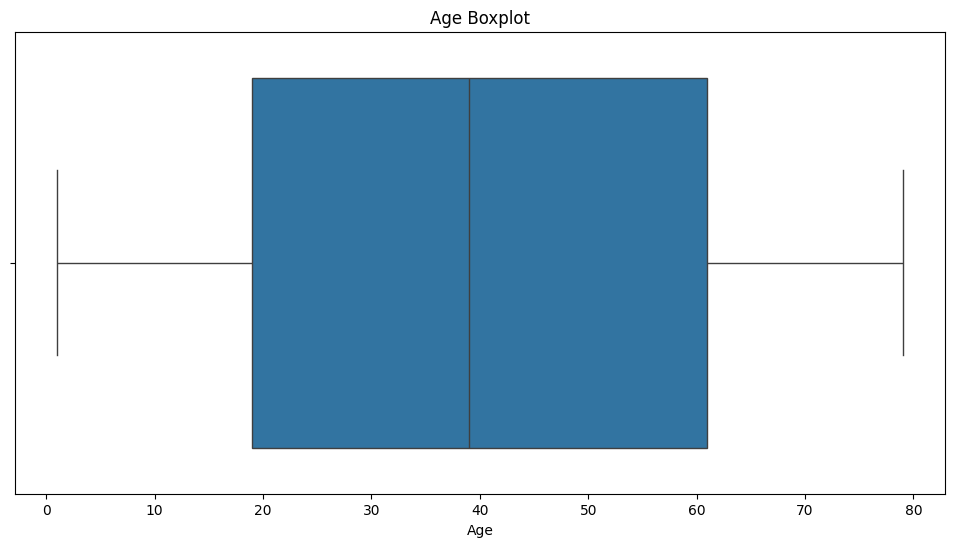

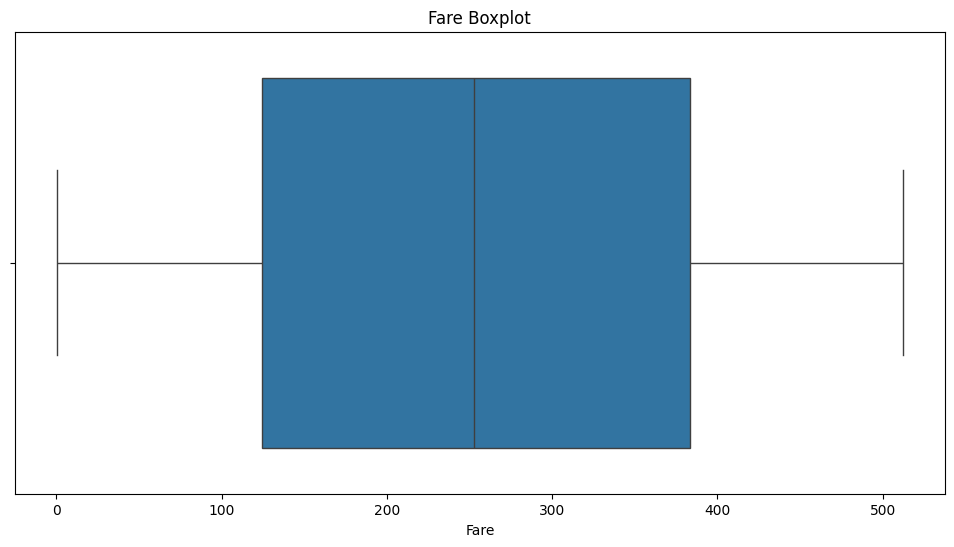

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 결측치 처리: Age의 결측치는 중위수로 대체
data['Age'] = data['Age'].fillna(data['Age'].median())

# Embarked의 결측치는 최빈값으로 대체
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Fare의 결측치는 중위수로 대체
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

# 이상치 처리: 나이와 요금의 이상치를 박스플롯으로 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['Age'])  # x축에 Age를 설정
plt.title('Age Boxplot')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=data['Fare'])  # x축에 Fare를 설정
plt.title('Fare Boxplot')
plt.show()


2. 데이터 전처리
범주형 변수를 인코딩하고 데이터를 스케일링합니다.

범주형 변수 인코딩

In [13]:
# 범주형 변수 인코딩
data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

# 필요한 열 선택
data = data[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']]


스케일링 및 불균형 데이터 처리

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# 스케일링
scaler = StandardScaler()
data[['Age', 'Fare']] = scaler.fit_transform(data[['Age', 'Fare']])

# 불균형 데이터 처리: Oversampling
majority = data[data.Survived == 0]
minority = data[data.Survived == 1]

minority_upsampled = resample(minority,
                              replace=True,     # 샘플링 시 복원 추출
                              n_samples=len(majority),    # 다수 클래스의 수와 같게 맞춤
                              random_state=42) # 시드 설정

data_upsampled = pd.concat([majority, minority_upsampled])


3. 모델링
로지스틱 회귀, 결정 트리, 랜덤 포레스트, SVM을 사용하여 생존 여부를 예측합니다.

데이터 분할 및 모델링

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 데이터 분할
X = data_upsampled.drop('Survived', axis=1)
y = data_upsampled['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# 모델 훈련
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} 모델 훈련 완료.")


Logistic Regression 모델 훈련 완료.
Decision Tree 모델 훈련 완료.
Random Forest 모델 훈련 완료.
SVM 모델 훈련 완료.


4. 모델 성능 평가
교차 검증과 혼동 행렬, 정확도, 정밀도, 재현율 등의 평가 지표를 계산합니다.

성능 평가

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# 성능 평가
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    print(f"{name} 모델 성능 평가:")
    print(f"  정확도: {accuracy:.2f}")
    print(f"  정밀도: {precision:.2f}")
    print(f"  재현율: {recall:.2f}")
    print(f"  교차 검증 점수: {cv_scores.mean():.2f}")
    print("  혼동 행렬:\n", confusion_matrix(y_test, y_pred))
    print()


Logistic Regression 모델 성능 평가:
  정확도: 0.48
  정밀도: 0.44
  재현율: 0.59
  교차 검증 점수: 0.50
  혼동 행렬:
 [[47 71]
 [39 55]]

Decision Tree 모델 성능 평가:
  정확도: 0.73
  정밀도: 0.66
  재현율: 0.78
  교차 검증 점수: 0.72
  혼동 행렬:
 [[81 37]
 [21 73]]

Random Forest 모델 성능 평가:
  정확도: 0.72
  정밀도: 0.65
  재현율: 0.78
  교차 검증 점수: 0.75
  혼동 행렬:
 [[79 39]
 [21 73]]

SVM 모델 성능 평가:
  정확도: 0.49
  정밀도: 0.44
  재현율: 0.62
  교차 검증 점수: 0.53
  혼동 행렬:
 [[45 73]
 [36 58]]

